In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on May 15 2025

@author: pablo
"""

from roboticstoolbox import RevoluteMDH, DHRobot
from spatialmath import SE3
import roboticstoolbox as rtb
import numpy as np




In [5]:

# Datos del doble péndulo
L = 0.2  # metros
w = 0.02 # metros
m = 1.5 # Kg
Jm = 0.0001
B = 0.1
N = 10
rg = np.array([L/2,0,0]) # El centro de masa está en la mitad de la barra
Ig = np.array([[1/12*m*(w**2+w**2),0,0],[0,1/12*m*(w**2+L**2),0],[0,0,1/12*m*(w**2+L**2)]]) # Matriz de inercia


        # Crear la estructura del robot
dp = DHRobot([
        # Modelo por DH proximal (o modificado)
        RevoluteMDH(a=0, alpha=0, d=0, m=m, r=rg, I=Ig, Jm=Jm, B=B, G=N),
        RevoluteMDH(a=L, alpha=0, d=0, m=m, r=rg, I=Ig,  Jm=Jm, B=B, G=N)
        ], 
        name='dp', 
        gravity = np.array([0, -9.8,0]),
        tool = SE3(L, 0, 0)
        )   
        
print(dp)
print(dp.dynamics())

# Estudiamos la dinámica para q_din
q_din = np.array([0, np.pi/2])
qp_din = np.array([0, 0])
print("POSE en la que estudiamos la dinámica para el control\n",dp.fkine(q_din))

# Matriz de inercia completa Mu=M+Jm*N^2
Mu = dp.inertia(q_din)
#tf = dp.jointdynamics(qp_din, q_din)
print(Mu)




DHRobot: dp, 2 joints (RR), dynamics, modified DH parameters
┌──────┬──────┬─────┬────┐
│ aⱼ₋₁ │ ⍺ⱼ₋₁ │ θⱼ  │ dⱼ │
├──────┼──────┼─────┼────┤
│    0 │ 0.0° │  q1 │  0 │
│  0.2 │ 0.0° │  q2 │  0 │
└──────┴──────┴─────┴────┘

┌──────┬─────────────────────────────────────┐
│ tool │ t = 0.2, 0, 0; rpy/xyz = 0°, 0°, 0° │
└──────┴─────────────────────────────────────┘

┌───────┬──────┬──────────────┬─────────────────────────────────────────┬─────────┬──────┬────────┬─────┐
│   j   │  m   │      r       │                    I                    │   Jm    │  B   │   Tc   │  G  │
├───────┼──────┼──────────────┼─────────────────────────────────────────┼─────────┼──────┼────────┼─────┤
│ link1 │  1.5 │  0.1,  0,  0 │  0.0001,  0.00505,  0.00505,  0,  0,  0 │  0.0001 │  0.1 │  0,  0 │  10 │
│ link2 │  1.5 │  0.1,  0,  0 │  0.0001,  0.00505,  0.00505,  0,  0,  0 │  0.0001 │  0.1 │  0,  0 │  10 │
└───────┴──────┴──────────────┴─────────────────────────────────────────┴─────────┴──────┴────────┴─────

Función de transferencia G(s):

        1
-----------------
0.1101 s^2 + 10 s


Polos del sistema: [-90.82652134+0.j   0.        +0.j]
Ceros del sistema: []


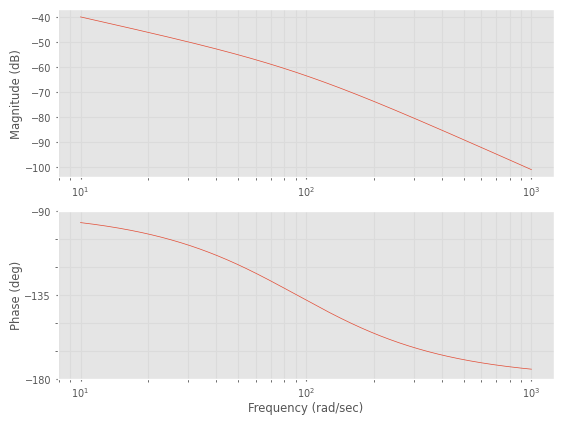

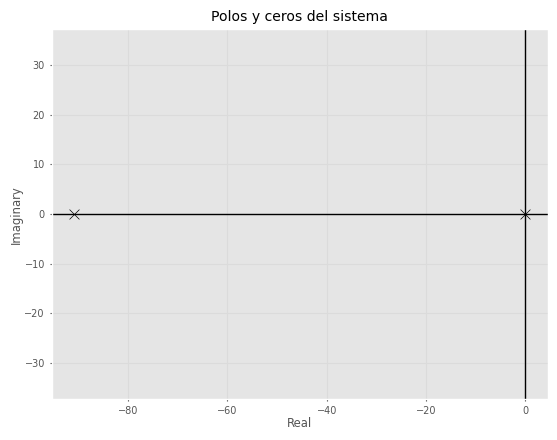

In [91]:
import control as ctl
import matplotlib.pyplot as plt

# Linealización del doble péndulo
# Coeficientes del numerador y denominador
eje = 1

numerador = [1]    
denominador = [Mu[eje-1,eje-1], B*N**2,0 ]

# Crear el sistema de transferencia
G = ctl.TransferFunction(numerador, denominador)

# Mostrar la función de transferencia
print("Función de transferencia G(s):")
print(G)

# Diagrama de Bode
mag, phase, omega = ctl.bode(G, dB=True)

# Polos y ceros
poles_G = ctl.pole(G)
zeros_G = ctl.zero(G)

print("\nPolos del sistema:", poles_G)
print("Ceros del sistema:", zeros_G)

# Gráfico de polos y ceros
plt.figure()
ctl.pzmap(G, title="Polos y ceros del sistema")
plt.show()


In [92]:
# 1. Definir el controlador PID: Kp + Ki/s + Kd*s

if eje==1: # Eje 1
    Kp = 400.0
    Ti = 0.8
    Td = -1/poles_G[0].real
else:
    # Eje 2
    Kp = 400.0
    Ti = 0.6
    Td = -1/poles_G[0].real



In [93]:
# Ajuste por ZN en eje 1
if eje==1: # Eje 1
    Ku = 280
    Tu = (14.7-13.4)/10
else:
    # Eje 2
    Ku=1100
    Tu=(7.17-6.95)/10

print("Ku: ", Ku, "Tu: ", Tu)
Kp = 0.6*Ku 
Td = 0.5 * Tu
Ti = 0.125 * Tu 
print("Kp: ", Kp, "Ti: ", Ti, "Td: ", Td)


Ku:  280 Tu:  0.1299999999999999
Kp:  168.0 Ti:  0.016249999999999987 Td:  0.06499999999999995


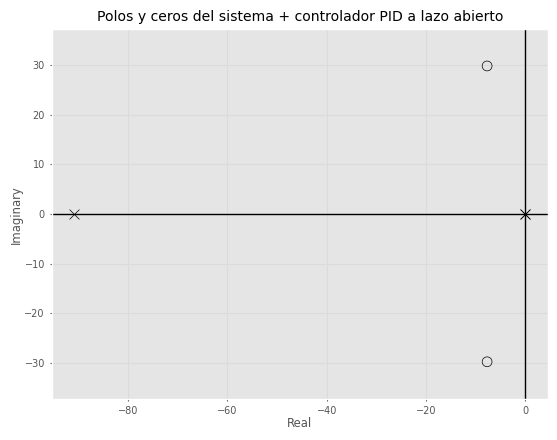

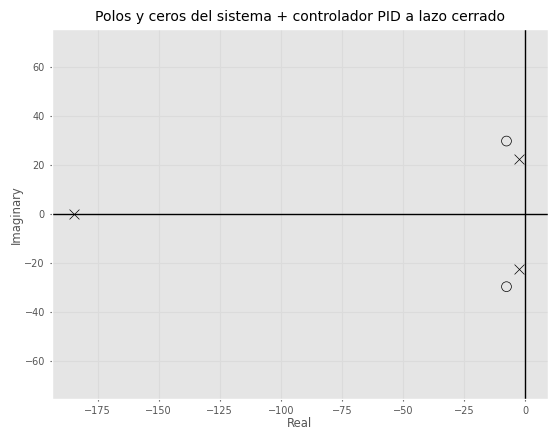

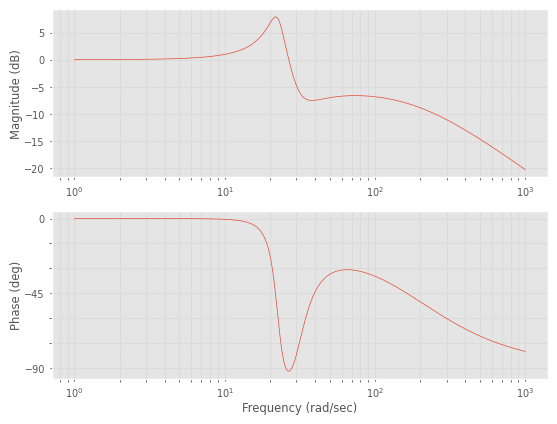

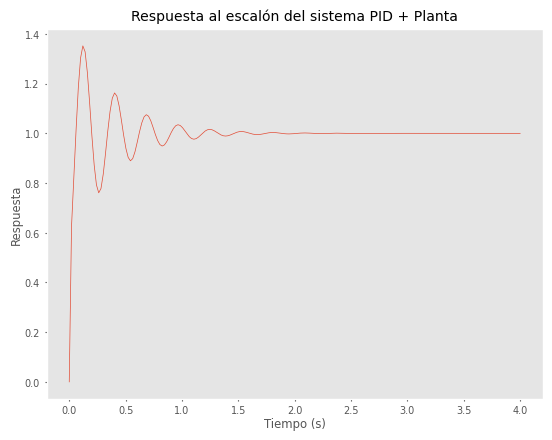

Sobrepico: 35.20 %
Tiempo de pico: 0.12 s
Frecuencia de corte: 4.55 Hz
Ajuste del controlador del eje  1
Ganancia proporcional (Kp): 168.00
Ganancia integral (Ki): 10338.46
Ganancia derivativa (Kd): 10.92


In [94]:

PID = ctl.TransferFunction(Kp * np.array([Td, 1, 1/Ti]), [1, 0])

# 2. Sistema en lazo abierto Gol (PID * Planta)
Gol = PID * G
Gcl = ctl.feedback(Gol, 1)  # Sistema en lazo cerrado

plt.figure()
ctl.pzmap(Gol, title="Polos y ceros del sistema + controlador PID a lazo abierto") 
plt.show()


plt.figure()
ctl.pzmap(Gcl, title="Polos y ceros del sistema + controlador PID a lazo cerrado")
plt.show()


# 3. Diagrama de Bode
mag, phase, omega = ctl.bode(Gcl, dB=True)

# 4. Respuesta al escalón
t = np.linspace(0, 4, 200)
t, y = ctl.step_response(Gcl, T=t)
plt.figure()
plt.plot(t, y)
plt.title("Respuesta al escalón del sistema PID + Planta")
plt.xlabel("Tiempo (s)")
plt.ylabel("Respuesta")
plt.grid()
plt.show()

# 5. Calculo del sobrepico
# Valor final (asintótico)
y_final = y[-1]

# Máximo valor alcanzado
y_max = np.max(y)

# Sobrepico en porcentaje
Mp = (y_max - y_final) / y_final * 100
print(f"Sobrepico: {Mp:.2f} %")

# 6. Tiempo de pico
# El tiempo de pico es el tiempo que tarda la respuesta en alcanzar el valor máximo
t_peak = t[np.argmax(y)]
print(f"Tiempo de pico: {t_peak:.2f} s")

# 7. Frecuencia de corte
# La frecuencia de corte es la frecuencia a la que la magnitud de la respuesta es 1/sqrt(2) veces el valor máximo
cutoff_freq = omega[np.where(mag < 1/np.sqrt(2))[0][0]]/2/np.pi
print(f"Frecuencia de corte: {cutoff_freq:.2f} Hz")

# 8. Calculo de ganancias
print("Ajuste del controlador del eje ", eje)
print(f"Ganancia proporcional (Kp): {Kp:.2f}")
print(f"Ganancia integral (Ki): {Kp/Ti:.2f}")
print(f"Ganancia derivativa (Kd): {Kp*Td:.2f}")